# BLIP: Inference Demo
 - [Image Captioning](#Image-Captioning)
 - [VQA](#VQA)
 - [Feature Extraction](#Feature-Extraction)
 - [Image Text Matching](#Image-Text-Matching)

In [ ]:
# install requirements
import sys
if 'google.colab' in sys.modules:
    print('Running in Colab.')
    !pip3 install transformers==4.15.0 timm==0.4.12 fairscale==0.4.4
    !git clone https://github.com/salesforce/BLIP
    %cd BLIP

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "5"
from PIL import Image
import requests
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms.functional import InterpolationMode
import matplotlib.pyplot as plt
import numpy as np
import foolbox as fb
from robustbench.data import load_cifar10
# x_test, y_test = load_cifar10(n_examples=50, data_dir="../data/")



device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def load_demo_image(image_size,device):
    # img_url = 'https://storage.googleapis.com/sfr-vision-language-research/BLIP/demo.jpg'
    image_path =  "./adv_images/00003.png"
    # raw_image = Image.open(requests.get(img_url, stream=True).raw).convert('RGB')   
    raw_image = Image.open(image_path).convert('RGB')

    w,h = raw_image.size
    display(raw_image.resize((w//5,h//5)))
    
    transform = transforms.Compose([
        transforms.Resize((image_size,image_size),interpolation=InterpolationMode.BICUBIC),
        transforms.ToTensor(),
        transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))
        ]) 
    image = transform(raw_image).unsqueeze(0).to(device)   
    return image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def forward(model, images, captions, eps=8/255):
        r"""
        Overridden.
        """

        images = images.clone().detach().to(device)
        # labels = labels.clone().detach().to(device)

        # if targeted:
        #     target_labels = self.get_target_label(images, labels)

        # loss = nn.CrossEntropyLoss()

        images.requires_grad = True
        cost = model(images, captions)

        # Calculate loss
        # if self.targeted:
        #     cost = -loss(outputs, target_labels)
        # else:
        # cost = loss(outputs, labels)

        # Update adversarial images
        grad = torch.autograd.grad(cost, images,
                                   retain_graph=False, create_graph=False)[0]

        adv_images = images + eps*grad.sign()
        adv_images = torch.clamp(adv_images, min=0, max=1).detach()

        return adv_images

In [2]:
class CustomDataset(Dataset):
    def __init__(self, image_folder, label_file, transform=None):
        self.image_folder = image_folder
        self.label_file = label_file
        self.transform = transform
        self.image_paths, self.labels = self.load_data()

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        image_path = self.image_paths[index]
        label = self.labels[index]

        image = Image.open(image_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

    def load_data(self):
        image_paths = []
        labels = []

        with open(self.label_file, 'r') as file:
            for line in file:
                label = int(line.strip())
                labels.append(label)

        for i in range(len(labels)):
            image_paths.append(os.path.join(self.image_folder, "{}.png".format(i)))

        

        return image_paths, labels

# Set your image folder path and label file path
image_folder = './experiment_1/stl_10/clean_images/'
label_file = './experiment_1/stl_10/labels.txt'


# Create an instance of the custom dataset

In [3]:
image_size = 384
transform = transforms.Compose([
        transforms.Resize((image_size,image_size),interpolation=InterpolationMode.BICUBIC),
        transforms.ToTensor(),
        # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))
        ])
testset = CustomDataset(image_folder, label_file, transform=transform)
# testset = torchvision.datasets.CIFAR10(root="../data/",
#                                         train=False, transform=transform)
# testset = torchvision.datasets.STL10(root="../data/",
                                        # split="test", transform=transform, download=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False)
# classes = ('plane', 'car', 'bird', 'cat',
#            'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

classes = ['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck']
# classes = enumerate(classes, start=0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


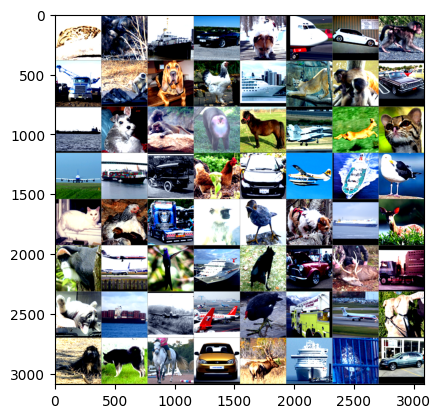

torch.Size([64, 3, 384, 384])
tensor([3, 7, 8, 2, 5, 0, 2, 7, 9, 7, 5, 1, 8, 3, 7, 2, 8, 5, 7, 7, 6, 0, 4, 3,
        0, 8, 2, 1, 2, 0, 8, 1, 3, 1, 9, 7, 1, 5, 8, 4, 7, 0, 1, 8, 5, 2, 4, 9,
        3, 8, 0, 0, 1, 9, 0, 5, 7, 5, 6, 2, 4, 8, 1, 2])


In [4]:
dataiter = iter(testloader)
image, label = next(dataiter)
imshow(torchvision.utils.make_grid(image))
# image = image.to(device)
print(image.shape)
print(label)


# Image Captioning
Perform image captioning using finetuned BLIP model

In [4]:
from models.blip import blip_decoder

image_size = 384
# image = load_demo_image(image_size=image_size, device=device)

model_url = 'https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_base_capfilt_large.pth'
model_path = "./checkpoints/model_base_capfilt_large.pth"
    
model = blip_decoder(pretrained=model_path, image_size=image_size, vit='base')
model.eval()
model = model.to(device)
# model_fb = fb.PyTorchModel(model, bounds=(0, 1))

reshape position embedding from 196 to 576
load checkpoint from ./checkpoints/model_base_capfilt_large.pth


In [ ]:
_, advs, success = fb.attacks.LinfPGD(rel_stepsize=0.1, steps=20)(model_fb, x_test.to('cuda:0'), y_test.to('cuda:0'), epsilons=[8/255])

In [ ]:
image_adv = forward(model, image, 'a woman sitting on the beach with a dog')#.cpu()#.detach().numpy()
imshow(torchvision.utils.make_grid(image_adv.cpu()))

In [ ]:
image = image.to(device)
with torch.no_grad():
    # beam search
    caption = model.generate(image, sample=False, num_beams=3, max_length=20, min_length=5) 
    # nucleus sampling
    # caption = model.generate(image, sample=True, top_p=0.9, max_length=20, min_length=5) 
    print('caption: '+caption[0])

In [5]:
from tqdm import tqdm
captions = []
with torch.no_grad():
    for i,batch in enumerate(tqdm(testloader)):
        image, label = batch[0].to(device), batch[1]
        # beam search
        caption = model.generate(image, sample=False, num_beams=3, max_length=20, min_length=5) 
        # nucleus sampling
        # caption = model.generate(image, sample=True, top_p=0.9, max_length=20, min_length=5) 
        # print('caption: '+caption[0])
        captions.extend(caption)

100%|██████████| 125/125 [24:14<00:00, 11.63s/it]


In [ ]:
captions[0]

In [6]:
inputFile = "./experiment_1/stl_10/blip_captions.txt"

# Opening the given file in write mode
with open(inputFile, 'w') as filedata:

   # Traverse in each element of the input list 
   for item in captions:
   
      # Writing each element of the list into the file
      # Here “%s\n” % syntax is used to move to the next line after adding an item to the file.
        filedata.write("%s\n" % item)

In [ ]:
labels = []
with open('./adversarial_images/labels.txt', 'r') as filehandle:
    for line in filehandle:
        # Remove linebreak which is the last character of the string
        c = line[:-1]
        # Add item to the list
        labels.append(c)
print(len(labels))

In [ ]:
class_names

In [ ]:
inputFile = "./adversarial_images/captions.txt"

# Opening the given file in write mode
with open(inputFile, 'w') as filedata:

   # Traverse in each element of the input list 
   for item in captions:
   
      # Writing each element of the list into the file
      # Here “%s\n” % syntax is used to move to the next line after adding an item to the file.
        filedata.write("%s\n" % item.item())

In [ ]:
from torchvision.utils import save_image
dataiter = iter(testloader)
caption_list = []
for i in range(5):
    image, label = next(dataiter)
    image = image.to(device)
    generated_caption = 'this is an image of a {}'.format(classes[label])
    image_adv = forward(model, image, generated_caption)
    save_image(image_adv, 'adv_images/img_adv_{}.png'.format(i))
    with torch.no_grad():
        caption = model.generate(image, sample=False, num_beams=3, max_length=20, min_length=5)
        caption_adv = model.generate(image_adv, sample=False, num_beams=3, max_length=20, min_length=5)
    temp = {"label": classes[label],
            "caption": generated_caption,
            "clean_caption":caption,
            "adv_caption":caption_adv}
    caption_list.append(temp)
    # break

In [ ]:
caption_list

In [ ]:
import json
with open('caption_list.json', 'r') as f:
    caption_list = json.load(f)
caption_list[5]

In [ ]:
import json
with open('caption_list_cifar10.json', 'w') as f:
    json.dump(caption_list, f)

In [ ]:
bcount_clean = 0
count_adv = 0
for i in caption_list:
    if i['label'] in i['clean_caption'][0]:
        count_clean+=1
    if i['label'] in i['adv_caption'][0]:
        count_adv+=1
    

In [ ]:
count_adv = 0
for i in range(len(captions)):
    if calss_names[int(labels[i])] in captions[i]:
        count_adv+=1
print(count_adv/len(captions))

In [ ]:
print(len(caption_list), count_clean, count_adv/count_clean)

# VQA
Perform visual question answering using finetuned BLIP model

In [ ]:
from models.blip_vqa import blip_vqa

image_size = 480
image = load_demo_image(image_size=image_size, device=device)     

model_url = 'https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_base_vqa_capfilt_large.pth'
model_path = "./checkpoints/model_base_vqa_capfilt_large.pth"
    
model = blip_vqa(pretrained=model_path, image_size=image_size, vit='base')
model.eval()
model = model.to(device)

question = 'where is the woman sitting?'

with torch.no_grad():
    answer = model(image, question, train=False, inference='generate') 
    print('answer: '+answer[0])

# Feature Extraction

In [ ]:
from models.blip import blip_feature_extractor

image_size = 224
image = load_demo_image(image_size=image_size, device=device)     

model_url = 'https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_base.pth'
model_path = "./checkpoints/model_base.pth"
    
model = blip_feature_extractor(pretrained=model_path, image_size=image_size, vit='base')
model.eval()
model = model.to(device)

caption = 'a woman sitting on the beach with a dog'

multimodal_feature = model(image, caption, mode='multimodal')[0,0]
image_feature = model(image, caption, mode='image')[0,0]
text_feature = model(image, caption, mode='text')[0,0]

# Image-Text Matching

In [ ]:
from models.blip_itm import blip_itm

image_size = 384
image = load_demo_image(image_size=image_size,device=device)

model_url = 'https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_base_retrieval_coco.pth'
model_path = "./checkpoints/model_base_retrieval_coco.pth"
    
model = blip_itm(pretrained=model_path, image_size=image_size, vit='base')
model.eval()
model = model.to(device)

caption = 'a woman sitting on the beach with a dog'

print('text: %s' %caption)

itm_output = model(image,caption,match_head='itm')
itm_score = torch.nn.functional.softmax(itm_output,dim=1)[:,1]
print('The image and text is matched with a probability of %.4f'%itm_score)

itc_score = model(image,caption,match_head='itc')
print('The image feature and text feature has a cosine similarity of %.4f'%itc_score)